torch.arange(4.0) 生成浮点型张量（只有浮点型张量支持求导），内容是 [0., 1., 2., 3.]。

In [5]:
x.requires_grad_(True)
x.grad

requires_grad_(True) 是告诉 PyTorch：后续对 x 的运算需要构建计算图，用于自动求导。

In [6]:
y = 2*torch.dot(x,x)
y

tensor(28., grad_fn=<MulBackward0>)

- torch.dot(x, x) 是 x 的点积：0²+1²+2²+3² = 14。
- 乘以 2 后，y = 28.。
- 因为 x 开启了求导追踪，PyTorch 会自动为 y 绑定grad_fn（反向传播函数），这里是MulBackward0（乘法操作的反向传播逻辑），所以输出是 tensor(28., grad_fn=<MulBackward0>)。

In [7]:
y.backward()
x.grad

tensor([ 0.,  4.,  8., 12.])

y.backward() 会根据计算图，自动求导 dy/dx_i：
- 已知 y = 2*(x₀² + x₁² + x₂² + x₃²)，对每个x_i求导得 dy/dx_i = 4x_i。
- 代入 x 的元素 [0.,1.,2.,3.]，得到梯度 [0., 4., 8., 12.]，存储在x.grad中。

In [8]:
x.grad == 4*x

tensor([True, True, True, True])

In [9]:
x.grad.zero_()
y = x.sum()
y.backward()
x.grad

tensor([1., 1., 1., 1.])

- x.grad.zero_()：梯度会累积（如果不清零，新梯度会叠加到旧梯度上），所以计算新梯度前必须清零。
- y = x.sum() 对应的导数：dy/dx_i = 1（对每个 x_i 的导数都是 1），所以反向传播后，x.grad是全 1 的张量。

In [12]:
x.grad.zero_()
y = x * x
y.sum().backward()
x.grad

tensor([0., 2., 4., 6.])

In [13]:
x.grad.zero_()
y = x*x
u = y.detach()
z = u*x

z.sum().backward()
x.grad == u

tensor([True, True, True, True])

In [14]:
x.grad.zero_()
y.sum().backward()
x.grad == 2*x

tensor([True, True, True, True])

In [16]:
def f(a):
    b =a *2
    while b.norm()<1000:
        b = b* 2
    if b.sum()>0:
        c =b
    else:
        c = 100 * b
    return c

In [17]:
a = torch.randn(size=(),requires_grad = True)
d = f(a)
d.backward()

In [18]:
a.grad == d/a

tensor(True)

## 一、自动微分
### 1. 核心概念
- 自动微分：深度学习框架通过跟踪计算过程构建「计算图」，自动反向传播求解梯度，避免手工求导的繁琐与错误，是优化算法的核心基础。
- 计算图：节点表示张量 / 运算，边表示张量流向，记录「输入→运算→输出」的完整流程，为反向传播提供依据。
- 反向传播：从输出（如损失函数）出发，沿计算图反向遍历，利用链式法则计算每个可训练参数的偏导数（梯度）。
### 2、关键操作

| 操作                | 作用           |注意 |
|---------------------|---------------------------------------|-------------------|
| `requires_grad_(True)` | 开启张量的梯度追踪（仅浮点型张量支持） |可在创建时直接指定：torch.tensor(..., requires_grad=True)|
| `backward()`        | 触发反向传播，计算梯度                |标量可直接调用；非标量需传入gradient参数（如torch.ones_like(y)）|
| `grad.zero_()`      | 清空张量的梯度缓存                    |PyTorch 梯度默认累积，每次新反向传播前必须清零|
| `detach()`          | 分离张量，切断梯度传播路径            |分离后的张量视为 “常数”，梯度不向后流经原张量|

### 3. 核心特性
- 梯度累积：多次调用backward()会将梯度叠加到grad中，需手动清零（适用于批量梯度下降）。
- 非标量梯度处理：非标量输出的导数是高阶张量，实际中常用sum()转为标量后求导（或传入gradient参数指定微分方向）。
- 控制流兼容：支持 Python 条件、循环等控制流，动态计算图会跟踪实际执行路径，仍可正确求导。
- 内存优化：默认反向传播后释放计算图，若需多次求导，需指定backward(retain_graph=True)。
### 4. 注意事项
- 仅浮点型张量（float32/float64）支持梯度追踪，整数张量无法求导。
- grad仅存储最终梯度结果，中间梯度会被自动释放（除非指定retain_graph）。
- detach()后的张量与原张量共享数据存储，修改其一会影响另一方（需用detach().clone()创建独立副本）。



### 二、练习题
#### 练习 1：为什么计算二阶导数比一阶导数的开销要更大？
问题分析
一阶导数：构建「输入→输出」的计算图，执行 1 次反向传播即可得到梯度。二阶导数：需先计算一阶导数（得到梯度张量grad1），再对grad1构建新的计算图，执行第 2 次反向传播得到二阶导数。
核心原因
计算量翻倍：需执行两次反向传播，且第二次反向传播的计算图基于第一次的梯度结果，运算逻辑更复杂。
内存开销增加：为计算二阶导数，需保留第一次反向传播的计算图（需设置retain_graph=True），中间变量无法释放，内存占用显著上升。
高阶张量维度爆炸：若输入是维度为n的张量，一阶导数是n维向量，二阶导数是n×n维 Hessian 矩阵，当n较大时（如深度学习中的百万维参数），存储和计算开销呈指数级增长。
#### 练习 2：反向传播后立即再次运行，会发生什么？
问题分析
PyTorch 默认在backward()执行后**释放计算图**（节省内存），若立即再次调用backward()，会因计算图已被销毁而报错。


In [19]:
import torch

# 初始化张量
x = torch.arange(4.0, requires_grad=True)
y = 2 * torch.dot(x, x)

# 第一次反向传播（正常执行）
y.backward()
print("第一次反向传播后的梯度：", x.grad)  # tensor([0., 4., 8., 12.])

# 第二次反向传播（报错）
try:
    y.backward()
except Exception as e:
    print("第二次反向传播报错：", e)

第一次反向传播后的梯度： tensor([ 0.,  4.,  8., 12.])
第二次反向传播报错： Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.


若需多次反向传播，需在第一次调用时指定`retain_graph=True`：

In [20]:
x.grad.zero_()  # 清零梯度
y = 2 * torch.dot(x, x)
y.backward(retain_graph=True)  # 保留计算图
print("第一次反向传播（保留图）：", x.grad)  # tensor([0., 4., 8., 12.])
x.grad.zero_()
y.backward()  # 第二次反向传播（可正常执行）
print("第二次反向传播：", x.grad)  # tensor([0., 4., 8., 12.])

第一次反向传播（保留图）： tensor([ 0.,  4.,  8., 12.])
第二次反向传播： tensor([ 0.,  4.,  8., 12.])


#### 练习 3：控制流例子中，将 a 改为随机向量或矩阵，会发生什么？
##### 原例子回顾
原代码中a是标量，f(a)满足f(a) = k*a（k是基于a的常量），梯度a.grad = d/a = k，与理论一致。
##### 当 a 为向量 / 矩阵时的变化
b.norm()计算张量的 L2 范数（向量：sqrt(sum(b_i²))；矩阵：sqrt(sum(b_ij²))），b.sum()计算所有元素的和，控制流（while/if）的逻辑基于张量的整体统计量，而非单个元素。
f(a)的每个元素仍满足f(a)_ij = k * a_ij（k是全局常量，由a的整体计算决定），因此梯度仍为k（元素 - wise）。
非标量输出d调用backward()时，需传入与d同形状的gradient参数（如torch.ones_like(d)），表示对每个元素的微分权重。

In [21]:
import torch

def f(a):
    b = a * 2
    while b.norm() < 1000:  # 基于向量L2范数的循环
        b = b * 2
    if b.sum() > 0:  # 基于向量所有元素和的条件
        c = b
    else:
        c = 100 * b
    return c

# a改为随机向量（维度为3）
a = torch.randn(3, requires_grad=True)
d = f(a)
print("输入a：", a)
print("输出d：", d)

# 非标量反向传播，传入gradient参数
d.backward(torch.ones_like(d))  # 求每个元素偏导数的和
print("梯度a.grad：", a.grad)
print("验证：a.grad == d / a（元素-wise）：", torch.allclose(a.grad, d / a))

输入a： tensor([-0.0604,  1.2432, -2.2766], requires_grad=True)
输出d： tensor([  -3092.9836,   63651.5078, -116564.2578], grad_fn=<MulBackward0>)
梯度a.grad： tensor([51200., 51200., 51200.])
验证：a.grad == d / a（元素-wise）： True


#### 练习 4：重新设计控制流梯度的例子（含条件 + 循环）
##### 设计思路
函数g(x)：输入向量x，先计算元素和s；若s < 5，则循环 2 次将x每个元素乘 3；否则循环 1 次乘 2；最后返回x的平方和，求g(x)关于x的梯度。
##### 理论分析
设循环后x变为k*x（k=3²=9或k=2¹=2，由s决定）。
输出`g(x) = sum((k*x_i)²) = k² * sum(x_i²)`，梯度`dg/dx_i = 2k²x_i`。


In [22]:
import torch

def g(x):
    s = x.sum()  # 计算元素和，决定控制流
    k = 1
    # 基于元素和的循环控制
    if s < 5:
        for _ in range(2):  # 循环2次
            x = x * 3
            k *= 3
    else:
        for _ in range(1):  # 循环1次
            x = x * 2
            k *= 2
    return x.square().sum(), k  # 返回输出和k（用于验证）

# 测试1：x元素和s < 5
x1 = torch.tensor([1.0, 0.5, 0.3], requires_grad=True)
y1, k1 = g(x1)
y1.backward()
print("测试1 - x1：", x1)
print("测试1 - k1（理论系数）：", k1)
print("测试1 - 梯度x1.grad：", x1.grad)
print("测试1 - 验证：2*k1²*x1 =", 2*k1**2*x1)
print("测试1 - 梯度是否正确：", torch.allclose(x1.grad, 2*k1**2*x1), "\n")

# 测试2：x元素和s ≥ 5
x2 = torch.tensor([2.0, 1.5, 1.6], requires_grad=True)
y2, k2 = g(x2)
y2.backward()
print("测试2 - x2：", x2)
print("测试2 - k2（理论系数）：", k2)
print("测试2 - 梯度x2.grad：", x2.grad)
print("测试2 - 验证：2*k2²*x2 =", 2*k2**2*x2)
print("测试2 - 梯度是否正确：", torch.allclose(x2.grad, 2*k2**2*x2))

测试1 - x1： tensor([1.0000, 0.5000, 0.3000], requires_grad=True)
测试1 - k1（理论系数）： 9
测试1 - 梯度x1.grad： tensor([162.0000,  81.0000,  48.6000])
测试1 - 验证：2*k1²*x1 = tensor([162.0000,  81.0000,  48.6000], grad_fn=<MulBackward0>)
测试1 - 梯度是否正确： True 

测试2 - x2： tensor([2.0000, 1.5000, 1.6000], requires_grad=True)
测试2 - k2（理论系数）： 2
测试2 - 梯度x2.grad： tensor([16.0000, 12.0000, 12.8000])
测试2 - 验证：2*k2²*x2 = tensor([16.0000, 12.0000, 12.8000], grad_fn=<MulBackward0>)
测试2 - 梯度是否正确： True


#### 练习 5：绘制 f (x)=sin (x) 和其导数（不用 cos (x)）的图像
###### 实现思路
生成均匀分布的x张量，开启梯度追踪。
计算f(x)=sin(x)，通过反向传播求梯度（即f’(x)）。
用matplotlib绘制f(x)和自动求导得到的f’(x)，对比理论上的cos(x)（验证正确性）。练习 5：绘制 f (x)=sin (x) 和其导数（不用 cos (x)）的图像
###### 实现思路
生成均匀分布的x张量，开启梯度追踪。
计算f(x)=sin(x)，通过反向传播求梯度（即f’(x)）。
用matplotlib绘制f(x)和自动求导得到的f’(x)，对比理论上的cos(x)（验证正确性）。

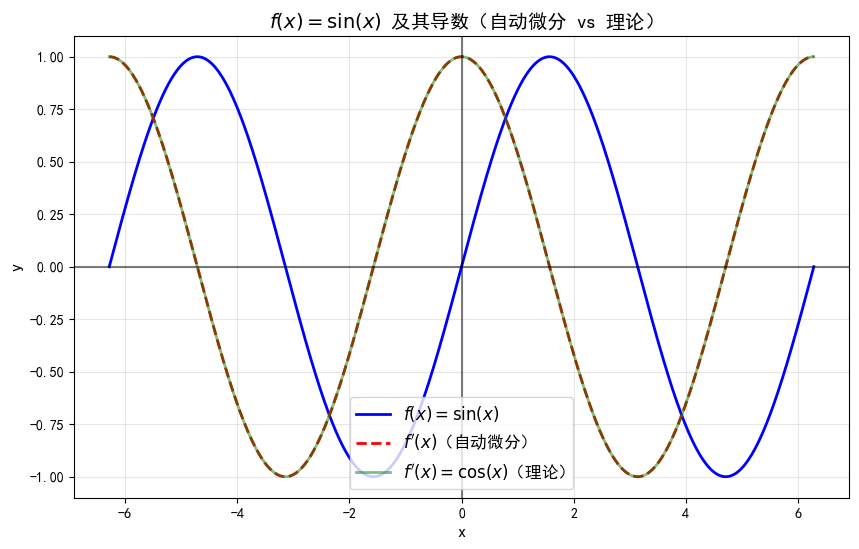

In [25]:
import torch
import matplotlib.pyplot as plt
import matplotlib as mpl

# -------------------------- 关键：设置中文显示 --------------------------
# 1. 全局设置：指定中文字体（根据操作系统选择，注释掉其他系统的字体）
# Windows系统（常用）
plt.rcParams['font.sans-serif'] = ['SimHei']  # 黑体（系统自带）
# macOS系统
# plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']  # 或 'Heiti TC'
# Linux系统
# plt.rcParams['font.sans-serif'] = ['WenQuanYi Zen Hei']  # 文泉驿正黑

# 2. 解决负号显示异常（避免负号变成方块）
plt.rcParams['axes.unicode_minus'] = False

# 1. 生成输入x（范围：[-2π, 2π]，共1000个点）
x = torch.linspace(-2 * torch.pi, 2 * torch.pi, 1000, requires_grad=True)

# 2. 计算f(x) = sin(x)
f_x = torch.sin(x)

# 3. 求导：对f_x求和（转为标量）后反向传播
f_x.sum().backward()
f_prime_x = x.grad  # f'(x) = 自动求导结果

# 4. 转换为numpy数组（绘图需用numpy）
x_np = x.detach().numpy()  # 分离张量，避免梯度追踪
f_x_np = f_x.detach().numpy()
f_prime_x_np = f_prime_x.numpy()
cos_x_np = torch.cos(x).detach().numpy()  # 理论导数（用于对比）

# 5. 绘图
plt.figure(figsize=(10, 6))
plt.plot(x_np, f_x_np, label=r'$f(x) = \sin(x)$', color='blue', linewidth=2)
plt.plot(x_np, f_prime_x_np, label=r"$f'(x)$（自动微分）", color='red', linestyle='--', linewidth=2)
plt.plot(x_np, cos_x_np, label=r"$f'(x) = \cos(x)$（理论）", color='green', alpha=0.5, linewidth=2)
plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title(r'$f(x) = \sin(x)$ 及其导数（自动微分 vs 理论）', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.5)
plt.axvline(x=0, color='black', linestyle='-', alpha=0.5)
plt.show()

- 红色虚线（自动微分得到的f’(x)）与绿色实线（理论cos(x)）完全重合，验证了自动微分的准确性。
- 核心逻辑：f(x)=sin(x)的导数通过backward()自动计算，无需手动编写cos(x)的表达式，体现了自动微分的便捷性。